In [46]:
from glob import glob
import pandas as pd
import numpy as np
from omegaconf import OmegaConf
from tqdm import tqdm
import logging
logger = logging.getLogger(__name__)

In [47]:
logdirs = [
    "logs/exp1",
    # "logs/exp1b",
    # "logs/fix2_exp2",
    # "logs/fix3_exp2",
    # "logs/exp4",
    # "logs/exp5",
]
# logdirs = ["logs/exp4"]

In [58]:
def extract_results(logdir: str) -> dict:
    files = glob("**/srf_estimates.csv", root_dir=logdir, recursive=True)
    logger.warning(f"Extracting {len(files)} files that look like {files[0]}")

    results = []

    for f in tqdm(files):
        comps = f.replace("/", "_").split("_")
        # family, seed, dataset, arch, strategy, backbone, *_ = comps
        dataset, family, strategy, backbone, arch, seed, *_ = comps
        expid = "_".join(comps[:-1])

        # config file
        conf_file = f.replace("srf_estimates.csv", ".hydra/config.yaml")
        # conf = OmegaConf.load(logdir + "/" + conf_file)

        # read pandas
        df = pd.read_csv(logdir + "/" + f)
        df["dataset"] = dataset
        df["family"] = family + "_" + arch + "_" + backbone
        df["seed"] = seed
        df["experiment"] = strategy
        df["arch"] = arch
        df["backbone"] = backbone
        df["expid"] = expid
        df["setup"] = dataset + "_" + family
        df["f"] = f
        df["shiftid"] = np.arange(df.shape[0])
        results.append(df)

    results = pd.concat(results)

    # obtain mse, variance, bias2 metrics
    error_metrics = results.groupby(
        ["dataset", "family", "experiment", "shiftid"]
    ).apply(_compute_metrics)
    error_metrics = (
        error_metrics.reset_index().groupby(["dataset", "family", "experiment"]).median()
    ).drop(columns=["shiftid"])

    # rank by seed too. Ranks are compute from the average mse along the curve
    curve_train_mse = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "train_mse"})
    )
    curve_test_mse = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "test_mse"})
    )
    curve_train_mse["train_rank"] = (
        curve_train_mse.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .train_mse
    )
    curve_test_mse["test_rank"] = (
        curve_test_mse.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .test_mse
    )
    ranks = curve_train_mse.merge(
        curve_test_mse, on=["dataset", "family", "seed", "experiment"]
    )

    return dict(
        results=results,
        metrics=error_metrics,
        ranks=ranks,
        # roc=roc,
        # auc=auc,
    )


def _compute_metrics(x: pd.DataFrame) -> pd.Series:
    out = dict(
        train_mse=np.abs(x["train_srf"] - x["true_train_srf"]).sum(),
        test_mse=np.abs(x["test_srf"] - x["true_test_srf"]).sum(),
        n=x.shape[0],
        # train_bias2=(x["train_srf"].mean() - x["true_train_srf"].mean()) ** 2,
        # test_bias2=(x["test_srf"].mean() - x["true_test_srf"].mean()) ** 2,
        # train_variance=x["train_srf"].var(),
        # test_variance=x["test_srf"].var(),
    )
    return pd.Series(out.values(), index=out.keys())

In [59]:
results_ = []
for logdir in logdirs:
    logger.info(f"Extracting results from {logdir}")
    results_.append(extract_results(logdir))
keys = list(results_[0].keys())

# append dataframes of elements of results
results = results_[0]
for other_results in results_[1:]:
    for key in keys:
        results[key] = pd.concat([results[key], other_results[key]])

results["metrics"] = (
    results["metrics"]
    .reset_index()
    .sort_values(["dataset", "family", "train_mse"], ascending=False)
)

Extracting 9178 files that look like news_gaussian/tresnet-clever-telescope_vc_large/37/srf_estimates.csv
100%|██████████| 9178/9178 [00:22<00:00, 404.47it/s]


In [60]:
# remove row limits
pd.set_option("display.max_rows", None, "display.max_columns", None)
results["metrics"].set_index(["dataset", "family", "experiment"])

train_mse    test_mse  \
dataset family            experiment                                         
tcga-3  gaussian_large_vc aipw                      445.791082  441.976868   
                          tmle-clever               409.573413  405.544233   
                          ipw-multips                41.414331   39.666687   
                          ipw-ps                     36.156090   20.632562   
                          outcome                    34.326745   34.523789   
                          ipw-hybrid                 22.595442   13.190580   
                          ipw-classifier             20.952268   10.416938   
                          vcnet                      16.204619   66.686184   
                          ipw-telescope              15.651907   28.512801   
                          tresnet-clever-telescope   12.191761   13.032982   
                          tresnet-clever-1           10.653732   12.323446   
                          tresnet-clever-ps           7.068269    9.722589   
                          tarnet                      6.638887    3.043203   
                          tresnet-clever-splines      6.227396    6.749023   
                          tresnet-clever              4.071907    5.569492   
tcga-2  gaussian_large_vc aipw                      531.382228  528.256480   
                          tmle-clever               509.552600  506.373689   
                          outcome                    24.172862   24.212392   
                          vcnet                      18.401679   22.031979   
                          tresnet-clever-telescope   14.758056   21.858436   
                          tresnet-clever-1           13.446875   13.528676   
                          ipw-telescope              11.941083   13.789766   
                          tarnet                      9.491429    7.855882   
                          ipw-ps                      8.209264   11.610108   
                          tresnet-clever-splines      7.632265    8.280035   
                          tresnet-clever              7.138647    7.360356   
                          tresnet-clever-ps           7.066940    7.406747   
                          ipw-classifier              6.924825    8.602739   
                          ipw-multips                 6.810741    6.256471   
                          ipw-hybrid                  4.101087    5.816640   
tcga-1  gaussian_large_vc aipw                      508.131339  502.337509   
                          tmle-clever               490.439382  489.027998   
                          vcnet                      61.833210   54.436180   
                          tresnet-clever-1           50.538482   51.305348   
                          outcome                    50.481973   50.274268   
                          tresnet-clever-telescope   47.844796   46.786617   
                          tarnet                     39.799113   35.028572   
                          ipw-ps                     34.153689   22.964563   
                          tresnet-clever-ps          33.448584   32.358392   
                          tresnet-clever-splines     31.071389   31.433212   
                          ipw-multips                30.664553   24.923007   
                          ipw-classifier             29.826356   26.237607   
                          ipw-telescope              28.565765   27.446297   
                          tresnet-clever             22.425917   22.971488   
                          ipw-hybrid                 16.733035   14.751497   
sim-N   gaussian_large_vc tmle-clever               569.879458  569.366453   
                          aipw                      546.576227  543.772657   
                          outcome                    42.937694   44.615909   
                          vcnet                      21.217521   30.182881   
                          tresnet-clever-1           17.280304   21.753766 

In [61]:
# (
#     results["ranks"]
#     .groupby(["family", "dataset", "experiment"])
#     .mean()
#     .drop(columns=["seed"])
# )

In [62]:
r = results["results"]
ecols = [ "family", "dataset", "seed"]
r["train_error"] = r["train_srf"] - r["true_train_srf"]
r["test_error"] = r["test_srf"] - r["true_test_srf"]
# m1 = "ipw-classifier" # "tresnet-clever-ps"
# m2 = "ipw-ps" # "vcnet"
m1 = "tresnet-clever"
m2 = "tarnet"
df1 = r[r.experiment == m1][["train_error", "test_error", "shiftid"] + ecols]
df2 = r[r.experiment == m2][["train_error", "test_error", "shiftid"] + ecols]
dfd = pd.merge(df1, df2, on=["shiftid"] + ecols, suffixes=["_1", "_2"])
dfd["train_err_diff"] = dfd["train_error_1"].abs() - dfd["train_error_2"].abs()
dfd["test_err_diff"] = dfd["test_error_1"].abs() - dfd["test_error_2"].abs()
dfd = dfd.drop(columns=["train_error_1", "train_error_2", "test_error_1", "test_error_2"])
dfd["shiftid"] = dfd["shiftid"].astype(int)
# dfd.head()

In [67]:
# compute mean and standard errors
# for standard errors must use 1.96 * std / sqrt(n)
def lci95(x):
    return x.mean() - 1.96 * x.std() / np.sqrt(len(x))
def uci95(x):
    return x.mean() + 1.96 * x.std() / np.sqrt(len(x))
def iqr75(x):
    return x.quantile(0.75)
def iqr25(x):
    return x.quantile(0.25)

# dfd.drop(columns=["seed", "shiftid"]).groupby(["family", "dataset"]).agg(["mean", "std", lci95, uci95])
dfd.drop(columns=["seed", "shiftid"]).groupby(["family", "dataset"]).agg(["median", iqr25, iqr75])

train_err_diff                     test_err_diff  \
                                  median     iqr25     iqr75        median   
family            dataset                                                    
gaussian_large_vc ihdp         -0.004914 -0.079298  0.030974      0.228514   
                  ihdp-B       -0.003191 -0.055528  0.021654      0.248039   
                  news         -0.001753 -0.029523  0.006561     -0.036556   
                  sim-B         0.000235 -0.013336  0.019602      0.046575   
                  sim-N        -0.001876 -0.029099  0.009806      0.056221   
                  tcga-1       -0.028018 -0.157482  0.045419      0.042831   
                  tcga-2       -0.000024 -0.078286  0.080054      0.028373   
                  tcga-3       -0.001965 -0.036741  0.018497      0.051260   

                                               
                              iqr25     iqr75  
family            dataset                      
gaussian_large_vc ihdp     0.049416  0.588828  
                  ihdp-B  -0.113296  0.984414  
                  news    -0.226555  0.150502  
                  sim-B   -0.060451  0.158221  
                  sim-N   -0.064837  0.175627  
                  tcga-1  -0.059887  0.153145  
                  tcga-2  -0.053535  0.132427  
                  tcga-3   0.005210  0.096681

In [64]:
dfd.drop(columns=["seed"]).groupby(["family", "dataset", "shiftid"]).agg(["mean", "std"])

train_err_diff           test_err_diff  \
                                            mean       std          mean   
family            dataset shiftid                                          
gaussian_large_vc ihdp    0            -0.000055  0.001063      0.067149   
                          1            -0.004640  0.021335     -0.006168   
                          2            -0.009356  0.045348     -0.012861   
                          3            -0.012556  0.071317      0.094387   
                          4            -0.015947  0.097831      0.260532   
                          5            -0.019053  0.125207      0.440491   
                          6            -0.021937  0.153563      0.580097   
                          7            -0.024484  0.182756      0.625011   
                          8            -0.026782  0.212882      0.633232   
                          9            -0.028761  0.243881      0.601835   
                  ihdp-B  0             0.000117  0.001089      0.228918   
                          1            -0.000632  0.017740     -0.003721   
                          2            -0.002401  0.035486     -0.272544   
                          3            -0.004382  0.053546     -0.276077   
                          4            -0.007100  0.072131     -0.105778   
                          5            -0.010684  0.091815      0.192093   
                          6            -0.015297  0.112086      0.553107   
                          7            -0.021011  0.133984      0.937402   
                          8            -0.027545  0.156905      1.284475   
                          9            -0.034832  0.181073      1.504417   
                  news    0             0.000059  0.000397      0.116119   
                          1            -0.000481  0.007406     -0.195294   
                          2            -0.002774  0.017011     -0.221066   
                          3            -0.002973  0.025451     -0.228574   
                          4            -0.005632  0.031525     -0.197404   
                          5            -0.009457  0.041352     -0.131900   
                          6            -0.012297  0.049146     -0.030971   
                          7            -0.014801  0.056731      0.084877   
                          8            -0.017605  0.064624      0.198999   
                          9            -0.019594  0.072900      0.298985   
                  sim-B   0            -0.000044  0.001723      0.021555   
                          1             0.000030  0.007366     -0.006789   
                          2            -0.000058  0.015074      0.002731   
                          3             0.001806  0.021195      0.041895   
                          4             0.002726  0.027676      0.064348   
                          5             0.003044  0.034764      0.091636   
                          6             0.003533  0.038930      0.099840   
                          7             0.003438  0.048582      0.092810   
                          8             0.004566  0.055499      0.069093   
                          9             0.008516  0.061827      0.050592   
                  sim-N   0             0.000154  0.001226      0.070805   
                          1            -0.001130  0.010952      0.052690   
                          2            -0.001893  0.019499      0.034092   
                          3            -0.001881  0.028576      0.036492   
                          4            -0.009582  0.039587      0.049485   
                          5            -0.009082  0.044135      0.072417   
                          6            -0.005326  0.055432      0.067973   
                          7            -0.004592  0.066538      0.088293   
                          8            -0.005616  0.074835      0.076366   
                          9            -0.007679  0.082996      0.084690   
      

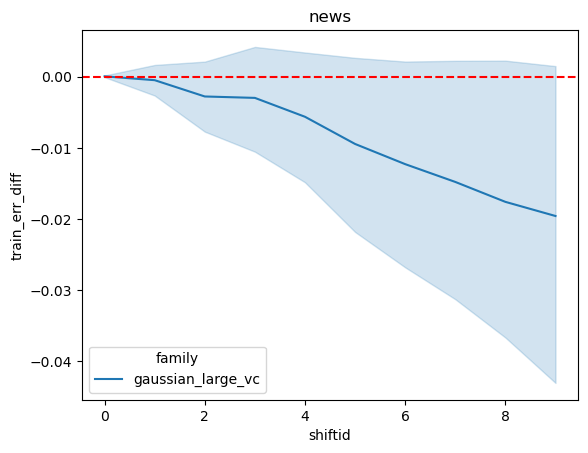

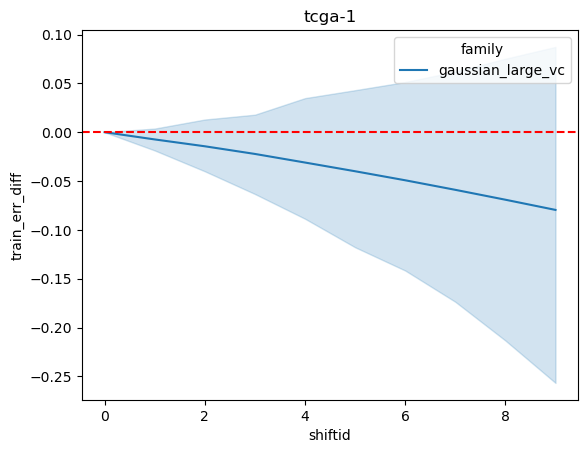

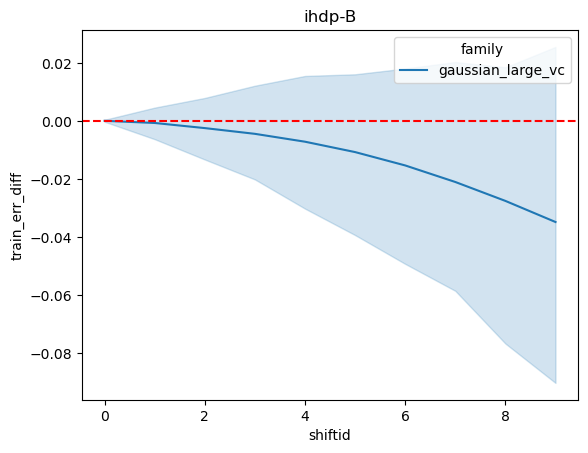

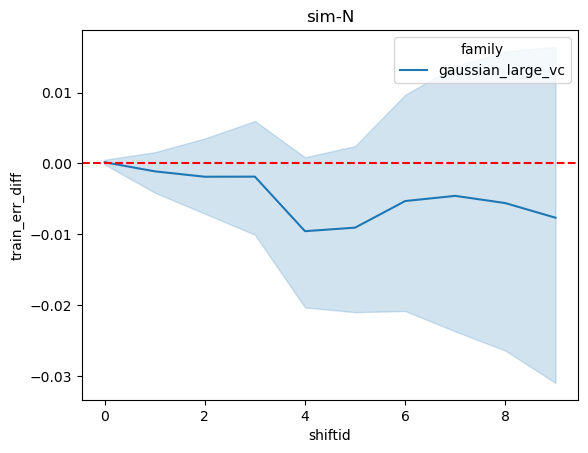

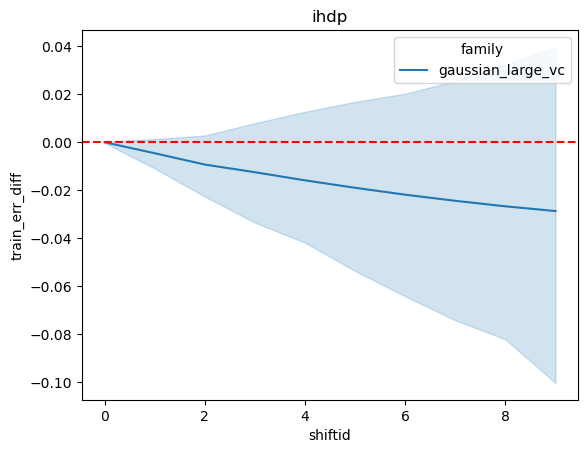

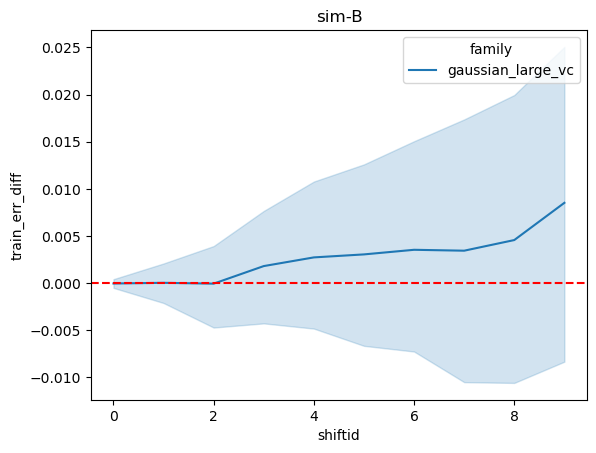

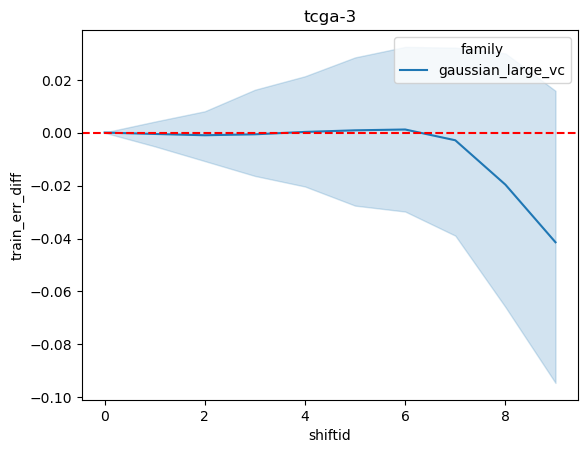

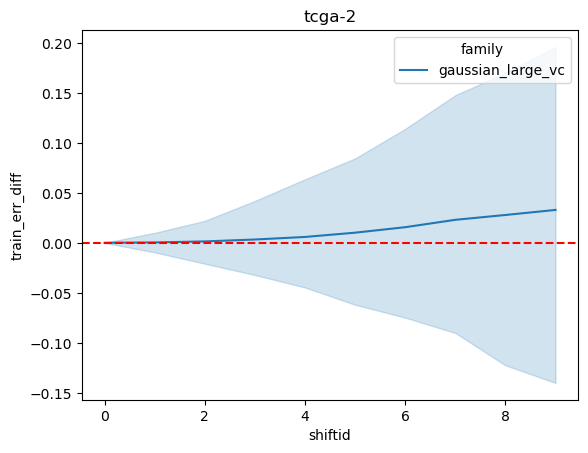

In [68]:
# make shiftid by train_err_diff plot
import seaborn as sns
import matplotlib.pyplot as plt

for d in dfd.dataset.unique():
    sdfd = dfd[dfd.dataset == d]
    f = sns.lineplot(
        data=sdfd,
        x="shiftid",
        y="train_err_diff",
        hue="family",
    )
    # add hline at 0 red dotted
    f.axhline(0, ls='--', color='red')    
    plt.title(d)
    plt.show()

In [66]:
# # make shiftid by train_err_diff plot
# import seaborn as sns
# import matplotlib.pyplot as plt

# for d in dfd.dataset.unique():
#     sdfd = dfd[dfd.dataset == d]
#     sns.lineplot(
#         data=sdfd,
#         x="shiftid",
#         y="test_err_diff",
#         hue="family",
#     )
#     plt.title(d)
#     plt.show()